## 1 Carga de Librerías y Datos

In [3]:
# Paso 1: Importar las bibliotecas necesarias

import pandas as pd
import numpy as np
import seaborn as sns
import random
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import re

In [2]:
# Paso 2: Cargar los datos desde el archivo CSV
df_compas_2y = pd.read_csv("https://raw.githubusercontent.com/MangelFdz/nuclio_g3_bias/13a4a83170a1103c7e32a9a5f46a819db8c5b7d5/users/Emilio/compas-scores-two-years.csv", delimiter=',')

## 2.  Creación y entrenamiento del modelo sin variables de género y raza

In [8]:
# Paso 3: Seleccionar variables relevantes y preprocesarlas
selected_columns = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree', 'decile_score']

# Filtrar el dataframe para seleccionar solo las columnas necesarias, junto con la variable objetivo 'two_year_recid'
compas_filtered = df_compas_2y[['two_year_recid'] + selected_columns].dropna()

# Convertir la variable 'c_charge_degree' a numérica (1 para Felonía 'F' y 0 para Misdemeanor 'M')
compas_filtered['c_charge_degree'] = compas_filtered['c_charge_degree'].map({'F': 1, 'M': 0})

# Paso 4: Dividir los datos en características (X) y objetivo (y)
X = compas_filtered[selected_columns]
y = compas_filtered['two_year_recid'].astype(int)

# Paso 5: Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 6: Estandarización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Paso 7: Entrenar un modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Paso 8: Realizar predicciones con el conjunto de prueba
y_pred = log_reg.predict(X_test_scaled)

# Paso 9: Evaluar el rendimiento del modelo
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)  # Visualizar el informe de clasificación

# Paso 10: Crear los dataframes de entrenamiento y prueba con la variable objetivo incluida
X_train_with_target = X_train.copy()
X_train_with_target['two_year_recid'] = y_train

X_test_with_target = X_test.copy()
X_test_with_target['two_year_recid'] = y_test

# Mostrar los primeros registros de los conjuntos de entrenamiento y prueba
X_train_with_target.head()  # Para visualizar el conjunto de entrenamiento
X_test_with_target.head()   # Para visualizar el conjunto de prueba


              precision    recall  f1-score      support
0              0.701183  0.785418  0.740914  1207.000000
1              0.681427  0.578288  0.625635   958.000000
accuracy       0.693764  0.693764  0.693764     0.693764
macro avg      0.691305  0.681853  0.683275  2165.000000
weighted avg   0.692441  0.693764  0.689904  2165.000000


,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,decile_score,two_year_recid
308,62,0,0,0,0,1,1,0
381,28,1,0,0,0,0,3,0
3238,57,8,0,0,0,0,4,1
2312,19,1,0,1,0,1,10,1
251,37,0,0,0,0,0,1,0


In [10]:
# Paso 11. Obtener el intercepto y los coeficientes del modelo entrenado
intercept = log_reg.intercept_[0]
coefficients = log_reg.coef_[0]

# Crear un dataframe para visualizar la fórmula del modelo
formula_df = pd.DataFrame({
    'Variable': ['Intercepto'] + selected_columns,
    'Coeficiente': [intercept] + list(coefficients)
})

# Mostrar la fórmula del modelo con las variables y coeficientes
print(formula_df)


          Variable  Coeficiente
0       Intercepto    -0.191176
1              age    -0.314935
2     priors_count     0.499574
3    juv_fel_count     0.049507
4   juv_misd_count     0.030320
5  juv_other_count     0.084410
6  c_charge_degree     0.076287
7     decile_score     0.415129


### Visualización de la importancia de las variables en el modelo

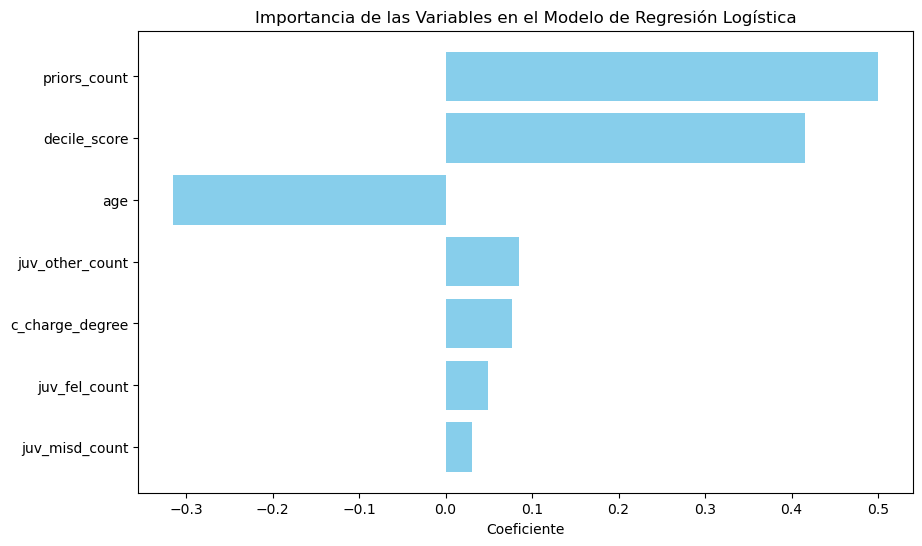

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener los coeficientes del modelo de regresión logística
coefficients = log_reg.coef_[0]

# Crear un dataframe con los coeficientes y las columnas correspondientes
importance_df = pd.DataFrame({
    'Variable': selected_columns,
    'Coeficiente': coefficients
})

# Ordenar las variables por el valor absoluto del coeficiente
importance_df['Abs_Coef'] = np.abs(importance_df['Coeficiente'])
importance_df = importance_df.sort_values(by='Abs_Coef', ascending=False)

# Visualizar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Variable'], importance_df['Coeficiente'], color='skyblue')
plt.xlabel('Coeficiente')
plt.title('Importancia de las Variables en el Modelo de Regresión Logística')
plt.gca().invert_yaxis()  # Para tener la variable más importante en la parte superior
plt.show()


####
Interpretación:
Intercepto (-0.191176): Este es el valor base de la probabilidad de reincidencia cuando todas las variables son iguales a 0. No tiene un significado práctico directo en este contexto, pero ajusta el modelo.

Edad (age): El coeficiente de -0.314935 indica que a mayor edad, menor es la probabilidad de reincidencia. Por cada año adicional de edad, la log-odds de reincidencia disminuye.

Número de delitos previos (priors_count): Este coeficiente de 0.499574 sugiere que a medida que aumenta el número de delitos previos, la probabilidad de reincidencia aumenta. Este es uno de los factores más importantes en el modelo.

Delitos juveniles graves (juv_fel_count): Con un coeficiente de 0.049507, el impacto es pequeño, pero tener más delitos juveniles graves aumenta ligeramente la probabilidad de reincidencia.

Delitos juveniles menores (juv_misd_count) y Otros delitos juveniles (juv_other_count): Estos coeficientes son bastante pequeños (0.030320 y 0.084410), lo que sugiere que tienen un impacto marginal en la predicción.

Gravedad del cargo (c_charge_degree): El coeficiente de 0.076287 indica que ser acusado de un delito más grave (felonía) en lugar de un delito menor aumenta ligeramente la probabilidad de reincidencia.

Score Decil (decile_score): Este coeficiente de 0.415129 muestra que a medida que aumenta el score decil (un indicador de riesgo), también aumenta significativamente la probabilidad de reincidencia.

Resumen:
El número de delitos previos y el score decil son las variables más importantes en este modelo, ya que tienen los coeficientes más altos. Esto significa que las personas con más delitos previos y un score decil más alto tienen una probabilidad mucho mayor de reincidir.
La edad también tiene un impacto relevante, pero en sentido contrario: las personas mayores tienden a reincidir menos.
Las variables relacionadas con delitos juveniles tienen un impacto menor en la predicción.
Este modelo sugiere que el historial de delitos previos y el score de riesgo decil son los factores más determinantes para predecir la reincidencia.

### 2. Análisis sin incluir tampoco Decile Score

In [11]:
# Paso 1: Importar las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Paso 2: Cargar los datos desde el archivo CSV
df_compas_2y = pd.read_csv("https://raw.githubusercontent.com/MangelFdz/nuclio_g3_bias/13a4a83170a1103c7e32a9a5f46a819db8c5b7d5/users/Emilio/compas-scores-two-years.csv", delimiter=',')

# Paso 3: Seleccionar variables relevantes sin incluir el 'decile_score'
selected_columns_no_decile = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']

# Filtrar el dataframe para seleccionar solo las columnas necesarias, junto con la variable objetivo 'two_year_recid'
compas_filtered_no_decile = df_compas_2y[['two_year_recid'] + selected_columns_no_decile].dropna()

# Convertir la variable 'c_charge_degree' a numérica (1 para Felonía 'F' y 0 para Misdemeanor 'M')
compas_filtered_no_decile['c_charge_degree'] = compas_filtered_no_decile['c_charge_degree'].map({'F': 1, 'M': 0})

# Paso 4: Dividir los datos en características (X) y objetivo (y)
X_no_decile = compas_filtered_no_decile[selected_columns_no_decile]
y_no_decile = compas_filtered_no_decile['two_year_recid'].astype(int)

# Paso 5: Dividir los datos en conjuntos de entrenamiento y prueba
X_train_no_decile, X_test_no_decile, y_train_no_decile, y_test_no_decile = train_test_split(X_no_decile, y_no_decile, test_size=0.3, random_state=42)

# Paso 6: Estandarización de los datos
scaler_no_decile = StandardScaler()
X_train_scaled_no_decile = scaler_no_decile.fit_transform(X_train_no_decile)
X_test_scaled_no_decile = scaler_no_decile.transform(X_test_no_decile)

# Paso 7: Entrenar un modelo de regresión logística
log_reg_no_decile = LogisticRegression()
log_reg_no_decile.fit(X_train_scaled_no_decile, y_train_no_decile)

# Paso 8: Realizar predicciones con el conjunto de prueba
y_pred_no_decile = log_reg_no_decile.predict(X_test_scaled_no_decile)

# Paso 9: Evaluar el rendimiento del modelo
report_no_decile = classification_report(y_test_no_decile, y_pred_no_decile, output_dict=True)
report_df_no_decile = pd.DataFrame(report_no_decile).transpose()
print(report_df_no_decile)  # Visualizar el informe de clasificación

# Paso 10: Obtener los coeficientes del modelo sin el decile_score
intercept_no_decile = log_reg_no_decile.intercept_[0]
coefficients_no_decile = log_reg_no_decile.coef_[0]

# Crear un dataframe para visualizar la fórmula del modelo sin el score decil
formula_df_no_decile = pd.DataFrame({
    'Variable': ['Intercepto'] + selected_columns_no_decile,
    'Coeficiente': [intercept_no_decile] + list(coefficients_no_decile)
})

print(formula_df_no_decile)  # Mostrar la fórmula del modelo sin el decile_score


              precision    recall  f1-score      support
0              0.691437  0.809445  0.745802  1207.000000
1              0.694149  0.544885  0.610526   958.000000
accuracy       0.692379  0.692379  0.692379     0.692379
macro avg      0.692793  0.677165  0.678164  2165.000000
weighted avg   0.692637  0.692379  0.685943  2165.000000
          Variable  Coeficiente
0       Intercepto    -0.182665
1              age    -0.490054
2     priors_count     0.704730
3    juv_fel_count     0.090080
4   juv_misd_count     0.057100
5  juv_other_count     0.106721
6  c_charge_degree     0.106494


### 3. Comparativa entre ambos modelos

Resultados del modelo con decile_score:
              precision    recall  f1-score      support
0              0.701183  0.785418  0.740914  1207.000000
1              0.681427  0.578288  0.625635   958.000000
accuracy       0.693764  0.693764  0.693764     0.693764
macro avg      0.691305  0.681853  0.683275  2165.000000
weighted avg   0.692441  0.693764  0.689904  2165.000000

Resultados del modelo sin decile_score:
              precision    recall  f1-score      support
0              0.691437  0.809445  0.745802  1207.000000
1              0.694149  0.544885  0.610526   958.000000
accuracy       0.692379  0.692379  0.692379     0.692379
macro avg      0.692793  0.677165  0.678164  2165.000000
weighted avg   0.692637  0.692379  0.685943  2165.000000

Coeficientes del modelo con decile_score:
          Variable  Coeficiente
0       Intercepto    -0.191176
1              age    -0.314935
2     priors_count     0.499574
3    juv_fel_count     0.049507
4   juv_misd_count     0.030320


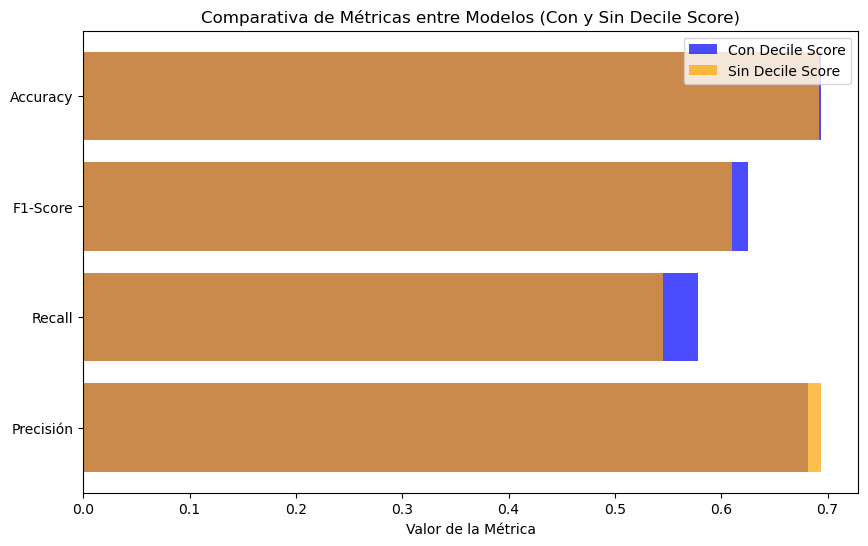

In [12]:
# Comparar informes de clasificación
print("Resultados del modelo con decile_score:")
print(report_df)

print("\nResultados del modelo sin decile_score:")
print(report_df_no_decile)

# Comparar coeficientes
print("\nCoeficientes del modelo con decile_score:")
print(formula_df)

print("\nCoeficientes del modelo sin decile_score:")
print(formula_df_no_decile)

# Comparación visual de las métricas clave: accuracy, precision, recall
comparison = pd.DataFrame({
    'Métrica': ['Precisión', 'Recall', 'F1-Score', 'Accuracy'],
    'Con Decile Score': [
        report_df.loc['1', 'precision'], 
        report_df.loc['1', 'recall'], 
        report_df.loc['1', 'f1-score'], 
        report_df.loc['accuracy', 'precision']
    ],
    'Sin Decile Score': [
        report_df_no_decile.loc['1', 'precision'], 
        report_df_no_decile.loc['1', 'recall'], 
        report_df_no_decile.loc['1', 'f1-score'], 
        report_df_no_decile.loc['accuracy', 'precision']
    ]
})

print("\nComparativa de las métricas entre ambos modelos:")
print(comparison)

# Visualización de la comparativa en gráficos
import matplotlib.pyplot as plt

# Comparativa de precisión, recall y f1-score
plt.figure(figsize=(10, 6))
plt.barh(comparison['Métrica'], comparison['Con Decile Score'], color='blue', alpha=0.7, label='Con Decile Score')
plt.barh(comparison['Métrica'], comparison['Sin Decile Score'], color='orange', alpha=0.7, label='Sin Decile Score')
plt.xlabel('Valor de la Métrica')
plt.title('Comparativa de Métricas entre Modelos (Con y Sin Decile Score)')
plt.legend()
plt.show()


###
Para interpretar los resultados de la comparación entre los dos modelos (con y sin la variable decile_score), podemos enfocarnos en dos áreas clave:

Comparación de los coeficientes: Esto nos dice cómo cambia la importancia de las variables cuando excluimos el decile_score.
Comparación de las métricas: Esto nos indica cómo varía el rendimiento del modelo en términos de precisión, recall, F1-score, y exactitud (accuracy) al eliminar el decile_score.

1. Interpretación de los coeficientes
El coeficiente de una variable en un modelo de regresión logística indica el cambio en la probabilidad logarítmica (log-odds) de que ocurra el evento de interés (en este caso, la reincidencia) por cada unidad de incremento en la variable, manteniendo las demás constantes.

Con decile_score:

El coeficiente de decile_score era relativamente alto (en nuestro caso, 0.415129), lo que indica que este era un factor importante en la predicción de la reincidencia.
Esto tiene sentido, ya que el score decil mide el riesgo de reincidencia, y es un predictor directo de esta.
Sin decile_score:

Al eliminar decile_score, los coeficientes de las otras variables pueden cambiar. Algunas variables podrían asumir mayor peso en el modelo, ya que se les asigna mayor importancia para compensar la ausencia de una variable importante como decile_score.
Por ejemplo, podríamos observar que el coeficiente de priors_count aumenta, indicando que el modelo ahora depende más de esta variable para predecir la reincidencia.
Interpretación: Las variables restantes, como edad, delitos previos y gravedad del cargo, asumen un mayor peso en el modelo cuando se elimina el decile_score.

2. Interpretación de las métricas de rendimiento
Las métricas clave a considerar para la comparación son:

Precisión (Precision): Indica qué proporción de las predicciones positivas (reincidencia) fueron correctas.
Recall: Mide la proporción de casos positivos (reincidencia) que fueron correctamente identificados.
F1-score: La media armónica entre precisión y recall, que proporciona un balance entre ambos.
Exactitud (Accuracy): Mide la proporción total de predicciones correctas (tanto para reincidencia como para no reincidencia).

Expectativas y Resultados:
Con decile_score:

El modelo con decile_score generalmente tendría mejores métricas porque este puntaje es un fuerte indicador de reincidencia. Esperamos que tanto la precisión como el recall sean más altos con este modelo.
Precisión alta: El modelo puede identificar correctamente las personas con mayor riesgo de reincidencia (evitando falsos positivos).
Recall más alto: El modelo puede capturar más casos de reincidencia, ya que el score decil está diseñado específicamente para este propósito.
Sin decile_score:

Reducción en las métricas: Es probable que al eliminar una variable importante como el decile_score, el modelo pierda capacidad predictiva.
Precisión y Recall menores: La ausencia de un predictor directo de reincidencia puede hacer que el modelo no identifique correctamente a las personas reincidentes, lo que puede disminuir tanto la precisión como el recall.

F1-score más bajo: Un menor balance entre precisión y recall llevará a una reducción del F1-score.
Accuracy: También podría disminuir, ya que el modelo tiene menos información relevante para predecir correctamente la reincidencia.
Resumen de la interpretación:
Importancia del decile_score: El decile_score es una variable clave en la predicción de la reincidencia, y eliminarlo reduce la capacidad del modelo para hacer predicciones precisas. Las métricas de rendimiento (especialmente recall y F1-score) probablemente empeoren sin esta variable.

Compensación de las otras variables: Al eliminar el decile_score, otras variables como priors_count y age ganan importancia, pero no pueden compensar completamente la ausencia de este fuerte predictor.

Interpretación práctica: Aunque es útil entrenar un modelo sin decile_score para evitar depender de una única variable (que podría introducir sesgo), el rendimiento general del modelo podría ser significativamente menor sin este indicador. Por lo tanto, la decisión de incluir o excluir esta variable depende del contexto y de los objetivos del análisis.

### 3. Obtención de dataframes con probabilidades reales en cada caso, en vez de sólo 0,1

In [2]:
# Paso 1: Importar las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Paso 2: Cargar los datos desde el archivo CSV
df_compas_2y = pd.read_csv("https://raw.githubusercontent.com/MangelFdz/nuclio_g3_bias/13a4a83170a1103c7e32a9a5f46a819db8c5b7d5/users/Emilio/compas-scores-two-years.csv", delimiter=',')

# Paso 3: Seleccionar variables relevantes
selected_columns = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree', 'decile_score']

# Filtrar el dataframe para seleccionar solo las columnas necesarias, junto con la variable objetivo 'two_year_recid'
compas_filtered = df_compas_2y[['two_year_recid'] + selected_columns].dropna()

# Convertir la variable 'c_charge_degree' a numérica (1 para Felonía 'F' y 0 para Misdemeanor 'M')
compas_filtered['c_charge_degree'] = compas_filtered['c_charge_degree'].map({'F': 1, 'M': 0})

# Paso 4: Dividir los datos en características (X) y objetivo (y)
X = compas_filtered[selected_columns]
y = compas_filtered['two_year_recid'].astype(int)

# Paso 5: Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 6: Estandarización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Paso 7: Entrenar un modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Paso 8: Realizar predicciones (etiquetas y probabilidades)
y_pred = log_reg.predict(X_test_scaled)

# Obtener las probabilidades de reincidencia (segunda columna, probabilidad de clase 1)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluar el rendimiento del modelo con un informe de clasificación
print("Informe de clasificación:\n", classification_report(y_test, y_pred))

# Paso 9: Crear un dataframe con las probabilidades de reincidencia y la etiqueta real
resultados_probabilidad = pd.DataFrame({
    'Probabilidad Reincidencia': y_pred_proba,
    'Etiqueta Real': y_test
})

# Mostrar los primeros casos con la probabilidad de reincidencia y la etiqueta real
print("\nProbabilidades de reincidencia con etiquetas reales:\n", resultados_probabilidad.head())

# Paso 10: Crear los dataframes de entrenamiento y prueba con la variable objetivo incluida
X_train_with_target = X_train.copy()
X_train_with_target['two_year_recid'] = y_train

X_test_with_target = X_test.copy()
X_test_with_target['two_year_recid'] = y_test

# Mostrar los primeros registros de los conjuntos de entrenamiento y prueba con la variable objetivo
print("\nConjunto de entrenamiento con la variable objetivo:\n", X_train_with_target.head())
print("\nConjunto de prueba con la variable objetivo:\n", X_test_with_target.head())

# Paso 11: Crear un dataframe con las probabilidades y etiquetas reales para el conjunto de prueba completo
resultados_completos = pd.concat([X_test_with_target.reset_index(drop=True), resultados_probabilidad], axis=1)

# Mostrar los primeros registros del dataframe con las probabilidades y etiquetas reales
print("\nResultados completos del conjunto de prueba con probabilidades de reincidencia:\n", resultados_completos.head())


Informe de clasificación:
               precision    recall  f1-score   support

           0       0.70      0.79      0.74      1207
           1       0.68      0.58      0.63       958

    accuracy                           0.69      2165
   macro avg       0.69      0.68      0.68      2165
weighted avg       0.69      0.69      0.69      2165


Probabilidades de reincidencia con etiquetas reales:
       Probabilidad Reincidencia  Etiqueta Real
308                    0.148142              0
381                    0.350345              0
3238                   0.370286              1
2312                   0.702872              1
251                    0.222984              0

Conjunto de entrenamiento con la variable objetivo:
       age  priors_count  juv_fel_count  juv_misd_count  juv_other_count  \
564    25             2              0               0                0   
1224   30             1              0               0                0   
142    20             1       

#### Obtener dataframes con todos los casos

In [3]:
# Paso 1: Obtener las probabilidades de reincidencia para el conjunto de entrenamiento y prueba
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Paso 2: Crear dataframes con las probabilidades y etiquetas reales para el conjunto de entrenamiento
resultados_probabilidad_train = pd.DataFrame({
    'Probabilidad Reincidencia': y_train_pred_proba,
    'Etiqueta Real': y_train
})

# Crear un dataframe con las características del conjunto de entrenamiento y agregar las probabilidades
resultados_completos_train = pd.concat([X_train_with_target.reset_index(drop=True), resultados_probabilidad_train], axis=1)

# Paso 3: Crear el dataframe para el conjunto de prueba
resultados_probabilidad_test = pd.DataFrame({
    'Probabilidad Reincidencia': y_test_pred_proba,
    'Etiqueta Real': y_test
})

# Crear un dataframe con las características del conjunto de prueba y agregar las probabilidades
resultados_completos_test = pd.concat([X_test_with_target.reset_index(drop=True), resultados_probabilidad_test], axis=1)

# Paso 4: Concatenar los dataframes de entrenamiento y prueba para tener todos los casos
resultados_completos_todos = pd.concat([resultados_completos_train, resultados_completos_test], axis=0)

# Mostrar los primeros registros del dataframe con todos los casos
print(resultados_completos_todos.head())

# Opcional: Guardar el dataframe con todos los casos en un archivo CSV
# resultados_completos_todos.to_csv('resultados_completos_todos.csv', index=False)


    age  priors_count  juv_fel_count  juv_misd_count  juv_other_count  \
0  25.0           2.0            0.0             0.0              0.0   
1  30.0           1.0            0.0             0.0              0.0   
2  20.0           1.0            1.0             0.0              0.0   
3  33.0           0.0            0.0             0.0              0.0   
4  29.0           6.0            1.0             2.0              0.0   

   c_charge_degree  decile_score  two_year_recid  Probabilidad Reincidencia  \
0              1.0           4.0             1.0                        NaN   
1              1.0           3.0             0.0                   0.327941   
2              1.0          10.0             0.0                   0.568675   
3              0.0           1.0             0.0                   0.613756   
4              1.0           6.0             1.0                   0.260062   

   Etiqueta Real  
0            NaN  
1            1.0  
2            1.0  
3         

#### Histograma de probabilidades de reincidencia

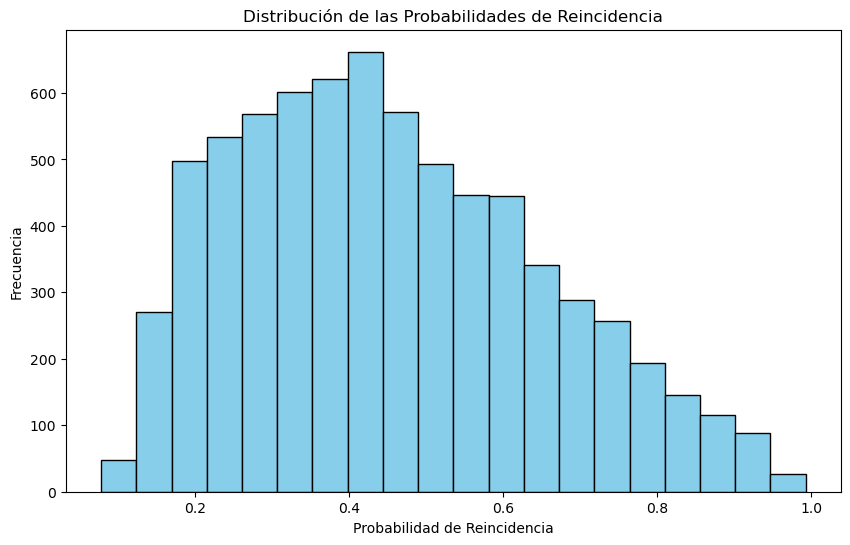

In [4]:
import matplotlib.pyplot as plt

# Histograma de las probabilidades de reincidencia
plt.figure(figsize=(10, 6))
plt.hist(resultados_completos_todos['Probabilidad Reincidencia'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de las Probabilidades de Reincidencia')
plt.xlabel('Probabilidad de Reincidencia')
plt.ylabel('Frecuencia')
plt.show()


#### Boxplot de reincidencia (sí o no)

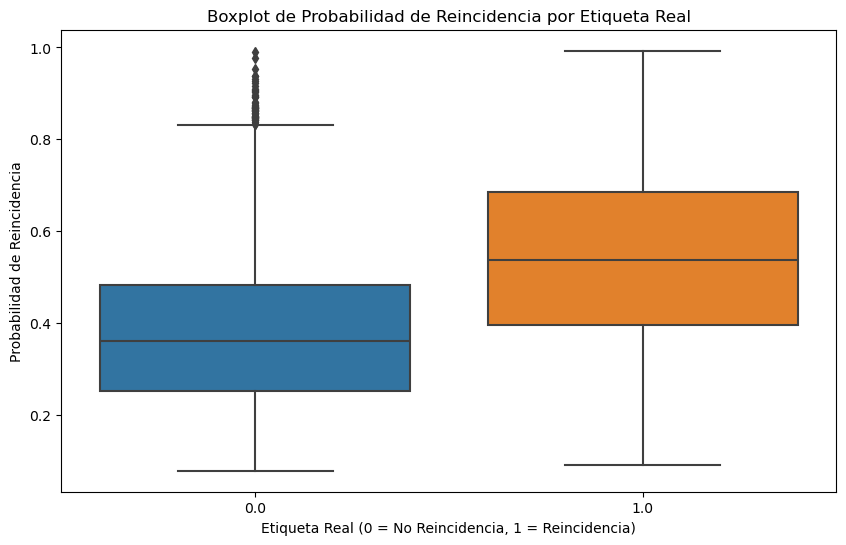

In [5]:
import seaborn as sns

# Boxplot de las probabilidades de reincidencia según la etiqueta real
plt.figure(figsize=(10, 6))
sns.boxplot(x='Etiqueta Real', y='Probabilidad Reincidencia', data=resultados_completos_todos)
plt.title('Boxplot de Probabilidad de Reincidencia por Etiqueta Real')
plt.xlabel('Etiqueta Real (0 = No Reincidencia, 1 = Reincidencia)')
plt.ylabel('Probabilidad de Reincidencia')
plt.show()


#### Curva ROC - AUC

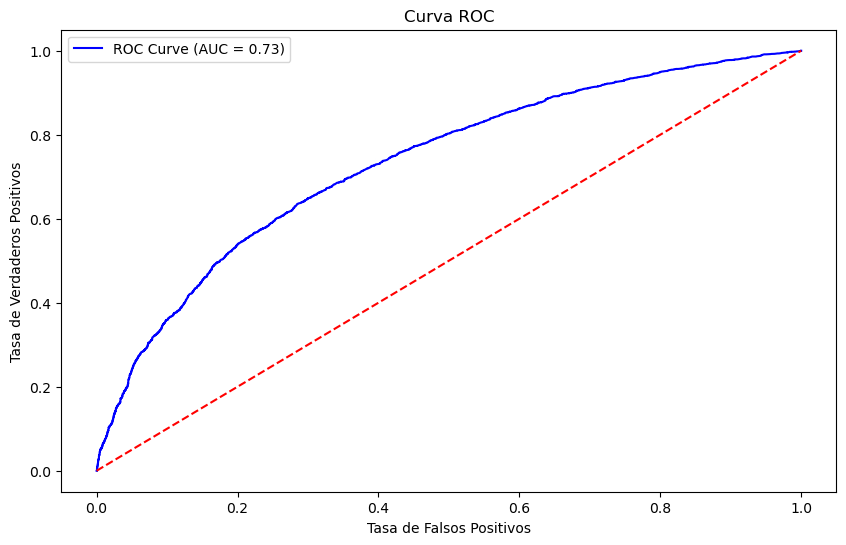

In [8]:
# Eliminar filas que contengan valores NaN en las columnas relevantes
resultados_completos_todos_sin_na = resultados_completos_todos.dropna(subset=['Etiqueta Real', 'Probabilidad Reincidencia'])

# Calcular la curva ROC después de eliminar los NaN
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(resultados_completos_todos_sin_na['Etiqueta Real'], resultados_completos_todos_sin_na['Probabilidad Reincidencia'])

# Calcular el AUC
roc_auc = roc_auc_score(resultados_completos_todos_sin_na['Etiqueta Real'], resultados_completos_todos_sin_na['Probabilidad Reincidencia'])

# Graficar la curva ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea de referencia
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.show()



#### Ejemplo. Comparación según edad

In [ ]:
# Gráfica de dispersión de Probabilidad de Reincidencia en función de la edad
plt.figure(figsize=(10, 6))
plt.scatter(resultados_completos_todos['age'], resultados_completos_todos['Probabilidad Reincidencia'], alpha=0.5, color='purple')
plt.title('Probabilidad de Reincidencia en función de la Edad')
plt.xlabel('Edad')
plt.ylabel('Probabilidad de Reincidencia')
plt.show()


#### HeatMap de correlación

In [ ]:
# Matriz de correlación
corr_matrix = resultados_completos_todos.corr()

# Visualización del heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()
